In [54]:
%cd C:\Users\yukir\Documents\GitHub\Sign_Recognition\py

from basic_preprocessing import *
from deeplearning_check import *
from machine_learning import *

gpu_check()
set_global_determinism(seed=SEED)

%cd C:\Users\yukir\Documents\Monicas_workspace\Knee

C:\Users\yukir\Documents\GitHub\Sign_Recognition\py
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12429037738060100663
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16797565939088312483
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9883535296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5299630727136419782
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1175499543468443476
physical_device_desc: "device: XLA_GPU device"
]
tf 2.2.0
keras 2.3.0-tf
set_global_determinism(seed=1337) 이거 꼭 해라
set_global_determinism(seed=1337) 이거 꼭 해라
set_global_determinism(seed=1337) 이거 꼭 해라
C:\Users\yukir\Documents\Monicas_workspace\Knee


In [55]:
%matplotlib inline
import numpy as np 
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model

In [56]:
from tensorflow.keras.applications import Xception

In [57]:
model = tf.keras.applications.xception.Xception(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

In [58]:
n_class = 5

# path to kaggle dataset
root_path = "C:\\Users\\yukir\\Documents\\Monicas_workspace\\NEW_Knee\\data\\archive\\"

# list of folders
folder_list = os.listdir(root_path)
image_path_list = []
label_list = []

# for each folder, get the image path and labels
for folder in folder_list:
    for label in range(n_class):
        
        # get all the images path inside the current folder
        image_list = os.listdir(f"{root_path}{folder}/{label}")
        # add to the image path list
        image_path_list += [ f"{root_path}{folder}/{label}/"+ path for path in image_list]
        
        # add labels to the label list
        label_list += [label] * len(image_list)

# convert to dataframe
df_train_kaggle = pd.DataFrame({"filepath" : image_path_list, "label": label_list})

In [59]:
df_train_kaggle.label.value_counts()

0    3857
2    2578
1    1770
3    1286
4     295
Name: label, dtype: int64

In [60]:
df_train_kaggle.shape

(9786, 2)

### class distribution

Text(0, 0.5, 'count')

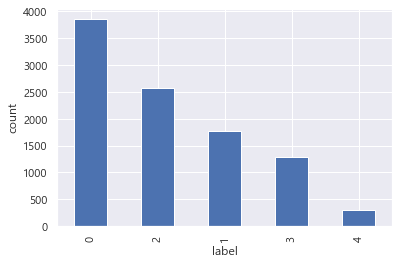

In [61]:
df_train_kaggle.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In [62]:
# train data generator object
train_aug = ImageDataGenerator(rescale=1./255)

# validation data generator object
valid_aug = ImageDataGenerator(rescale=1./255)

In [63]:
# create train generator
train_generator = train_aug.flow_from_dataframe(
dataframe=df_train_kaggle,
directory=None,
x_col="filepath",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 9786 validated image filenames.


In [64]:
%cd C:\Users\yukir\Documents\Monicas_workspace\NEW_Knee\data

C:\Users\yukir\Documents\Monicas_workspace\NEW_Knee\data


In [65]:
# !gdown --id "1NdDqPK4NLn2aV8ZdF5ilux1sfG6IyebC"

In [66]:
# read Train.csv file which contains image names and labels and preprocess them
compi_root_path= "C:\\Users\\yukir\\Documents\\Monicas_workspace\\NEW_Knee\\data\\KneeXray\\KneeXray\\"
df_val_compi = pd.read_csv(compi_root_path + "Train.csv")

# add absolute path to the image names
df_val_compi["filename"] = df_val_compi.filename.apply(lambda x: compi_root_path+"train/" + x)
df_val_compi.head()

,filename,label
0,C:\Users\yukir\Documents\Monicas_workspace\NEW...,0
1,C:\Users\yukir\Documents\Monicas_workspace\NEW...,1
2,C:\Users\yukir\Documents\Monicas_workspace\NEW...,0
3,C:\Users\yukir\Documents\Monicas_workspace\NEW...,1
4,C:\Users\yukir\Documents\Monicas_workspace\NEW...,2


Text(0, 0.5, 'count')

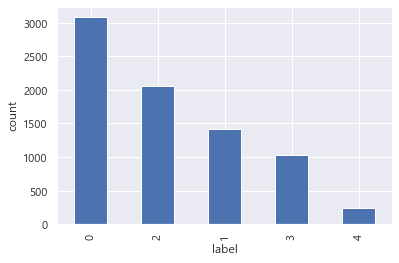

In [67]:
# class count of compitition dataset
df_val_compi.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In [68]:
# create validation generator
valid_generator = valid_aug.flow_from_dataframe( 
dataframe= df_val_compi,
x_col= "filename",
y_col= "label",
batch_size= 32,
seed= 42,
shuffle= True,
class_mode= "raw",
target_size= (224,224))

Found 7828 validated image filenames.


In [69]:
# compile
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),
                 metrics=["acc"],
                 loss= tf.keras.losses.sparse_categorical_crossentropy)

# callbacks and checkpoints
checkpoint_path = "xception_best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path,
                               monitor = 'val_acc',
                               verbose = 1,
                               save_weights_only=True,
                               save_best_only = True,
                               mode="max"),
              EarlyStopping(monitor='val_loss',
                            patience=5,
                            verbose=0),
              ReduceLROnPlateau(monitor='val_loss',
                                patience=5,
                                verbose=1)
]

In [70]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes= np.unique(df_train_kaggle.label.values),
                                                 y= df_train_kaggle.label.values)
class_weights = dict(enumerate(class_weights))

In [71]:
class_weights

{0: 0.5074410163339383,
 1: 1.1057627118644069,
 2: 0.7591931730023274,
 3: 1.5219284603421461,
 4: 6.63457627118644}

In [72]:
# create validation generator
valid_generator = valid_aug.flow_from_dataframe( 
dataframe= df_val_compi,
x_col= "filename",
y_col= "label",
batch_size= 32,
seed= 42,
shuffle= True,
class_mode= "raw",
target_size= (224,224))

Found 7828 validated image filenames.


In [73]:
# train the model
model.fit(
        train_generator,
        epochs=100,
        validation_data=valid_generator,
        callbacks=[my_callbacks],
        class_weight=class_weights)

# load best saved weights
model.load_weights(checkpoint_path)

Epoch 1/100


C:\Users\yukir\anaconda3\envs\tensorflow37\lib\site-packages\gdown\cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1NdDqPK4NLn2aV8ZdF5ilux1sfG6IyebC
To: C:\Users\yukir\Documents\Monicas_workspace\NEW_Knee\data\KneeXray.zip

  0%|          | 0.00/120M [00:00<?, ?B/s]
  0%|          | 524k/120M [00:00<01:43, 1.15MB/s]
  1%|          | 1.05M/120M [00:00<00:56, 2.11MB/s]
  2%|▏         | 2.10M/120M [00:00<00:28, 4.18MB/s]
  3%|▎         | 3.15M/120M [00:00<00:26, 4.45MB/s]
  4%|▎         | 4.19M/120M [00:01<00:25, 4.44MB/s]
  6%|▌         | 6.82M/120M [00:01<00:13, 8.16MB/s]
  7%|▋         | 7.86M/120M [00:01<00:12, 8.62MB/s]
  8%|▊         | 9.44M/120M [00:01<00:11, 9.49MB/s]
  9%|▉         | 11.0M/120M [00:01<00:10, 10.1MB/s]
 11%|█         | 12.6M/120M [00:01<00:10, 10.6MB/s]
 12%|█▏        | 14.2M/120M [00

306/306 [==============================] - ETA: 0s - loss: 4.1481 - acc: 0.2119
Epoch 00001: val_acc improved from -inf to 0.26648, saving model to xception_best.ckpt
306/306 [==============================] - 138s 450ms/step - loss: 4.1481 - acc: 0.2119 - val_loss: 2.1382 - val_acc: 0.2665 - lr: 1.0000e-05
Epoch 2/100
306/306 [==============================] - ETA: 0s - loss: 1.4420 - acc: 0.4407
Epoch 00002: val_acc improved from 0.26648 to 0.39997, saving model to xception_best.ckpt
306/306 [==============================] - 135s 441ms/step - loss: 1.4420 - acc: 0.4407 - val_loss: 1.5087 - val_acc: 0.4000 - lr: 1.0000e-05
Epoch 3/100
306/306 [==============================] - ETA: 0s - loss: 1.0418 - acc: 0.5184
Epoch 00003: val_acc improved from 0.39997 to 0.57256, saving model to xception_best.ckpt
306/306 [==============================] - 135s 442ms/step - loss: 1.0418 - acc: 0.5184 - val_loss: 1.0806 - val_acc: 0.5726 - lr: 1.0000e-05
Epoch 4/100
306/306 [======================

KeyboardInterrupt: 

In [ ]:
preds = model.evaluate(valid_generator)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

In [ ]:
predicition_compi = model.predict(valid_generator, steps= valid_generator.n/ BATCH_SIZE, verbose= 1)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(df_val_compi.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()

In [ ]:
xception_model.save_weights("knee_xray_ResNet152V2.h5")


### compition data로 더 가르키는거
https://www.kaggle.com/haidermasood/xception-osteoarthritis-kneexray

In [ ]:
# train and validation split on competition data
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df_train_kaggle,
                                   test_size=0.2,
                                   random_state=42,
                                   stratify= df_train_kaggle.label)

In [ ]:
# train and validation split on competition data
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df_val_compi,
                                   test_size=0.1,
                                   random_state=42,
                                   stratify= df_val_compi.label)

In [ ]:
train_generator = train_aug.flow_from_dataframe(
dataframe = X_train,
x_col="filepath",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

In [ ]:
valid_generator = valid_aug.flow_from_dataframe( 
dataframe=X_test,
x_col="filepath",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

In [ ]:
# number of steps to consider 1 as  epoch
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID =valid_generator.n//valid_generator.batch_size

In [ ]:
# kick off training
xception_model.fit(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=50,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID,callbacks=[my_callbacks])

In [ ]:
xception_model.save_weights("knee_final_xray_ResNet152V2.h5")

In [ ]:
# load best saved weights
xception_model.load_weights(checkpoint_path)

### **Confusion Matirx**

In [ ]:
from sklearn.metrics import precision_recall_curve
target_shape = 224
BATCH_SIZE = 1

# test generator
compi_gen = valid_aug.flow_from_dataframe(dataframe= X_test,
                            x_col= "filepath",
                            class_mode=None,
                            target_size= (target_shape, target_shape),
                            shuffle= False,
                            batch_size= BATCH_SIZE
                            )

In [ ]:
# prediction on train data
predicition_compi = model.predict(compi_gen, steps= compi_gen.n/ BATCH_SIZE, verbose= 1)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_prediction_compi =  np.argmax(predicition_compi, axis= 1)
cm = confusion_matrix(X_test.label, class_prediction_compi, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1, 2, 3, 4])
disp.plot()